# car_evaluation 데이터셋

- 컬럼 구성
    - price : 자동차 가격
    - maint : 자동차 유지 비용
    - doors : 자동차 문 개수
    - persons : 수용 인원
    - lug_capacity : 수하물 용량
    - safety : 안정성
    - output(종속 변수) : ck tkdxo
        - 아래의 범주 중 하나의 값을 가짐
            - unacc : 허용 불가능한 수준
            - acc : 허용 가능한 수준
            - good : 양호
            - vgood : 매우 좋음

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

# 데이터 준비

In [4]:
dataset = pd.read_csv("./data/car_evaluation.csv")

In [5]:
dataset.head()

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


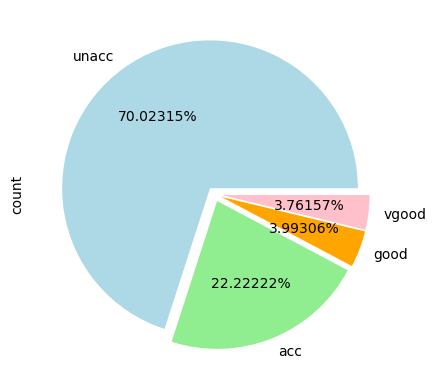

In [7]:
dataset["output"].value_counts().plot(kind = "pie", autopct = "%0.05f%%",
                                      colors = ["lightblue", "lightgreen", "orange", "pink"],
                                     explode = [0.05, 0.05, 0.05, 0.05])

plt.show()

In [8]:
# 데이터를 범주형 타입으로 변환
categorical_columns = ["price", "maint", "doors", "persons", "lug_capacity", "safety"]

In [9]:
# astype() 메서드를 이용하여 데이터를 범주형으로 변환
for category in categorical_columns:
    dataset[category] = dataset[category].astype("category")

- 범주형 데이터를 텐서로 변환하기 위한 절차
    - 범주형 데이터 -> astype("category") -> 넘파이 배열 -> 텐서

In [10]:
# 범주형 데이터를 넘파이 배열로 변환
dataset["price"].cat.codes

0       3
1       3
2       3
3       3
4       3
       ..
1723    1
1724    1
1725    1
1726    1
1727    1
Length: 1728, dtype: int8

In [12]:
price = dataset["price"].cat.codes.values
maint = dataset["maint"].cat.codes.values
doors = dataset["doors"].cat.codes.values
persons = dataset["persons"].cat.codes.values
lug_capacity = dataset["lug_capacity"].cat.codes.values
safety = dataset["safety"].cat.codes.values

In [13]:
categorical_data = np.stack([price, maint, doors, persons, lug_capacity, safety], 1)
categorical_data[:10]

array([[3, 3, 0, 0, 2, 1],
       [3, 3, 0, 0, 2, 2],
       [3, 3, 0, 0, 2, 0],
       [3, 3, 0, 0, 1, 1],
       [3, 3, 0, 0, 1, 2],
       [3, 3, 0, 0, 1, 0],
       [3, 3, 0, 0, 0, 1],
       [3, 3, 0, 0, 0, 2],
       [3, 3, 0, 0, 0, 0],
       [3, 3, 0, 1, 2, 1]], dtype=int8)

In [14]:
# 배열을 텐서로 변환
categorical_data = torch.tensor(categorical_data, dtype = torch.int64)
categorical_data[:10]

tensor([[3, 3, 0, 0, 2, 1],
        [3, 3, 0, 0, 2, 2],
        [3, 3, 0, 0, 2, 0],
        [3, 3, 0, 0, 1, 1],
        [3, 3, 0, 0, 1, 2],
        [3, 3, 0, 0, 1, 0],
        [3, 3, 0, 0, 0, 1],
        [3, 3, 0, 0, 0, 2],
        [3, 3, 0, 0, 0, 0],
        [3, 3, 0, 1, 2, 1]])

In [15]:
# 레이블로 사용할 컬럼을 텐서로 변환
outputs = pd.get_dummies(dataset["output"])
outputs

,acc,good,unacc,vgood
0,False,False,True,False
1,False,False,True,False
2,False,False,True,False
3,False,False,True,False
4,False,False,True,False
...,...,...,...,...
1723,False,True,False,False
1724,False,False,False,True
1725,False,False,True,False
1726,False,True,False,False


In [16]:
outputs = outputs.values
outputs

array([[False, False,  True, False],
       [False, False,  True, False],
       [False, False,  True, False],
       ...,
       [False, False,  True, False],
       [False,  True, False, False],
       [False, False, False,  True]])

In [17]:
outputs = torch.tensor(outputs).flatten()
outputs

tensor([False, False,  True,  ..., False, False,  True])

In [18]:
categorical_data.shape

torch.Size([1728, 6])

In [19]:
outputs.shape

torch.Size([6912])

In [20]:
# 각 범주 간의 세부적인 관계를 잘 파악하기 위해 임베딩
# 임베딩 크기는 각 컬럼의 고유값 수 나누기 2로 임의로 사용
categorical_column_sizes = [len(dataset[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size + 1)//2)) for col_size in categorical_column_sizes]

# (모든 범주형 컬럼의 고유값 수, 차원의 크기)
print(categorical_embedding_sizes)

[(4, 2), (4, 2), (4, 2), (3, 2), (3, 2), (3, 2)]


## 데이터 분할

In [21]:
# 데이터셋 분리 (8 :2)
total_records = categorical_data.shape[0]
test_records = int(total_records * 0.2)

In [22]:
total_records, test_records

(1728, 345)

In [26]:
categorical_train_data = categorical_data[:total_records - test_records]
categorical_test_data = categorical_data[total_records - test_records : total_records]

train_outputs = outputs[:total_records - test_records]
test_outputs = outputs[total_records - test_records : total_records]

In [27]:
print(len(categorical_train_data))
print(len(train_outputs))
print(len(categorical_test_data))
print(len(test_outputs))

1383
1383
345
345


## 모델 생성

In [28]:
class Model(nn.Module):
    def __init__(self, embedding_size, output_size, layers, p = 0.4):
        '''
        모델에서 사용될 파라미터와 신경망을 초기화하기 위한 용도
        객체가 생성될 때 자동으로 호출됨
        
        embedding_size : 범주형 컬럼의 임베딩 크기
        output_size : 출력층의 크기
        layers : 모든 계층에 대한 목록
        p : 드롭아웃(기본값 0.4)
        '''
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        
        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols
        
        for i in layers:
            # 전결합층
            all_layers.append(nn.Linear(input_size, i))
            # 활성화 함수
            all_layers.append(nn.ReLU(inplace = True))
            # 배치 정규화
            # 신경망 안에서 데이터의 평균과 분산을 조정
            all_layers.append(nn.BatchNorm1d(i))
            # 드롭아웃
            all_layers.append(nn.Dropout(p))
            input_size = i
            
        all_layers.append(nn.Linear(layers[-1], output_size))
        self.layers = nn.Sequential(*all_layers)
        
    def forward(self, x_categorical):
        '''
        학습 데이터를 입력받아서 연산을 진행
        모델 객체를 데이터와 함께 호출하면 자동으로 실행
        '''
        embeddings = []
        for i, e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:, i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)
        x = self.layers(x)
        return x

In [29]:
# Model 객체 생성
# (범주형 컬럼의 임베딩 크기, 출력 크기, 은닉층의 유닛, 드롭아웃)
model = Model(categorical_embedding_sizes, 4, [200, 100, 50], p = 0.4)
model

Model(
  (all_embeddings): ModuleList(
    (0-2): 3 x Embedding(4, 2)
    (3-5): 3 x Embedding(3, 2)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=4, bias=True)
  )
)

## 모델 파라미터 정의

- 손실 함수와 옵티마이저 정의

In [30]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [31]:
# CPU/GPU 사용 지정
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
# 같은 코드 => device = "cuda" if torch.cuda.is_avilable() else "cpu"

In [32]:
device

device(type='cpu')

## 모델 학습

In [33]:
epochs = 500
aggregated_losses = []
train_outputs = train_outputs.to(device = device, dtype = torch.int64)
categorical_train_data = categorical_train_data.to(device)

for i in range(epochs):
    i += 1
    y_pred = model(categorical_train_data)
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss)
    
    if i % 25 == 1:
        print(f"epoch: {i:3} loss: {single_loss.item():10.8f}")
        
    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()
    
print(f"epoch: {i:3} loss: {single_loss.item():10.8f}")

epoch:   1 loss: 1.50559580
epoch:  26 loss: 1.28147507
epoch:  51 loss: 1.21804416
epoch:  76 loss: 1.11874640
epoch: 101 loss: 1.00531209
epoch: 126 loss: 0.89317524
epoch: 151 loss: 0.80881441
epoch: 176 loss: 0.73818702
epoch: 201 loss: 0.67470825
epoch: 226 loss: 0.65286225
epoch: 251 loss: 0.62456453
epoch: 276 loss: 0.59930414
epoch: 301 loss: 0.60024935
epoch: 326 loss: 0.59235889
epoch: 351 loss: 0.59022194
epoch: 376 loss: 0.57278734
epoch: 401 loss: 0.57848883
epoch: 426 loss: 0.57280636
epoch: 451 loss: 0.57087487
epoch: 476 loss: 0.57727194
epoch: 500 loss: 0.56622994


## 테스트 데이터셋으로 모델 예측

In [35]:
test_outputs = test_outputs.to(device = device, dtype = torch.int64)
categorical_test_data = categorical_test_data.to(device)

with torch.no_grad():
    y_val = model(categorical_test_data)
    loss = loss_function(y_val, test_outputs)
    
print(f"Loss: {loss:.8f}")

Loss: 0.55062479
